# Convolução Numérica

Realizar a integral de convolução analiticamente pode ser problemático, mesmo para sistemas de matemática simbólica sofisticados.

Além disto, pode nem haver uma representação analítica da excitação, que pode, por exemplo, vir de medidas experimentais.

Neste caso podemos realizar a convolução numericamente. A convolução numérica existe no NumPy, Matlab, Octave, e em rotinas que podem ser chamadas de diversas linguagens de programação.

## Setup

In [13]:
import numpy as np
import matplotlib.pyplot as plt

## Resposta ao impulso unitário

Para nossa conveniência, vamos definir um objeto que armazena as propriedades de um oscilador harmônico amortecido e retorna a reposta ao impulto unitário para um vetor de tempos dados.

In [10]:
class DampedOsc:
    def __init__(self, m=1, c=0.12, k=40):
        self.m = m
        self.c = c
        self.k = k
        self.wn = np.sqrt(k/m)
        self.taun = 2*np.pi/self.wn
        self.cc = 2*m*self.wn
        self.zeta = self.c/self.cc
        self.wd = np.sqrt(1-self.zeta**2)*self.wn
        
    def gt(self, times):
        return np.exp(-self.zeta*self.wn*times)*np.sin(self.wd*times)/(self.m*self.wd)

### Quick check

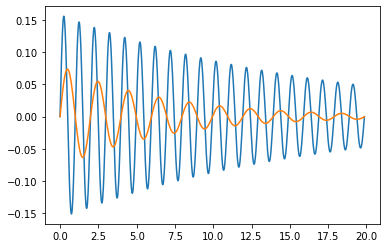

In [72]:
s1 = DampedOsc(m=1, c=0.12, k=40)
s2 = DampedOsc(m=4, c=1.2, k=40)
times = np.linspace(0, 20*s1.taun, 1000, endpoint=True)
g1 = s1.gt(times)
g2 = s2.gt(times)
fig, ax = plt.subplots()
ax.plot(times, g1.T)
ax.plot(times, g2.T)
plt.show()

## Convolução

O numpy fornece uma função que calcular a convolução numérica entre dois vetores, mas não é exatamente o que a gente precisa.

Podemos usá-la no entanto para construir uma função que calcula a resposta.

In [86]:
def conv_resp(a, b):
    """
    a, b must be 1d arrays of the same size.
    """
    c = np.empty_like(a)
    for i in np.arange(c.size):
        c[i] = np.convolve(a[:i+1], b[:i+1], 'valid')
    return c / c.size
    

## Funções

Vamos definir algumas funções para facilitar a vida.

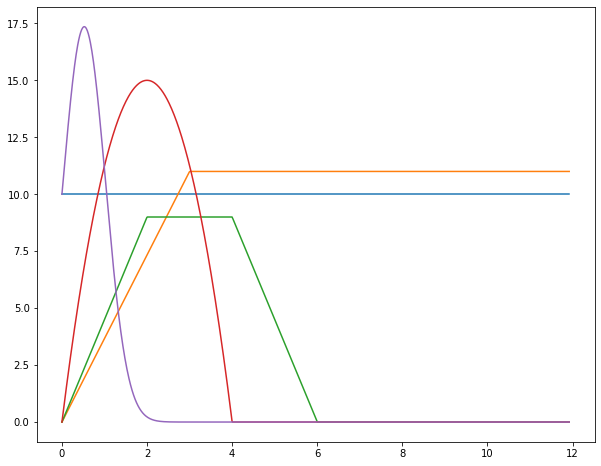

In [30]:
def make_step(A, times):
    step = np.empty_like(times)
    step.fill(A)
    return step

def make_ramp(A, duration, times):
    ramp = np.empty_like(times)
    ramp = np.where(times <= duration, times*A/duration, A)
    return ramp

def make_up_down(A, duration, times):
    ud = np.zeros_like(times)
    ud[times<=duration] = times[times<duration]*A/duration
    ud[(times>duration) & (times <= 2*duration)] = A
    idx = (times>2*duration) & (times<3*duration)
    ud[idx] = 2*A + A*(duration-times[idx])/duration
    return ud

def make_quad(A, duration, times):
    duration /= 2
    quad = np.empty_like(times)
    quad = np.where(times <= 2*duration, -A/duration**2*(times-2*duration)*times, 0.0)
    return quad

def make_exp(A, a, b, times):
    return A*np.exp(a*times-b*times**2)

s = make_step(10, times)
r = make_ramp(11, 3, times)
u = make_up_down(9, 2, times)
q = make_quad(15, 4, times)
e = make_exp(10, 2.1, 2, times)

fig, ax = plt.subplots()
ax.plot(times, s)
ax.plot(times, r)
ax.plot(times, u)
ax.plot(times, q)
ax.plot(times, e)
fig.set_size_inches(10, 8)
plt.show()

## Sistema Físico

Vamos redefinir o sistema físico aqui para que seja fácil  modificá-lo.

O oscilador amortecido vai ser representado por sua resposta ao impulso unitário. É importante escolher um número de pontos para o vetor 'times' de forma que haja um número suficiente de pontos para que a resposta e a força aplicada sejam bem representadas.

In [91]:
osc = DampedOsc(m=1, c=1.2, k=40)
nt = 10 # Número de períodos para calcular e plotar
times = np.linspace(0, 10*osc.taun, nt*200)
gt = osc.gt(times)

## Cálculo da resposta

### Degrau

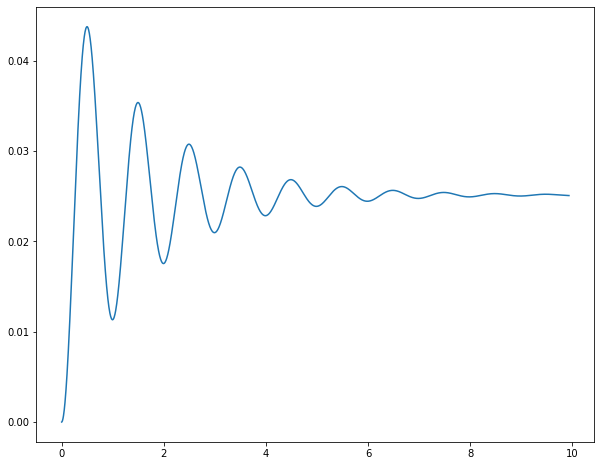

In [93]:
s = make_step(10, times)
xts = conv_resp(gt, s)
fig, ax = plt.subplots()
ax.plot(times, xts)
fig.set_size_inches(10, 8)
plt.show()

### Rampa

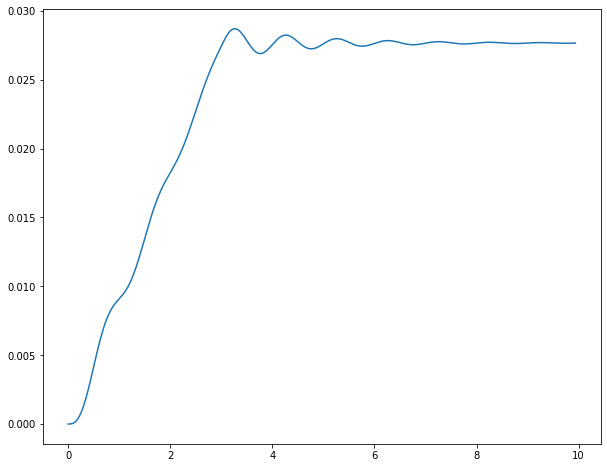

In [96]:
r = make_ramp(11, 3, times)
xtr = conv_resp(gt, r)
fig, ax = plt.subplots()
ax.plot(times, xtr)
fig.set_size_inches(10, 8)
plt.show()

### Up Down

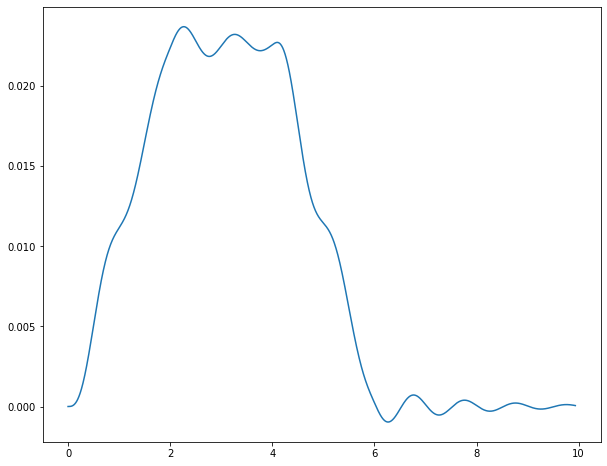

In [97]:
u = make_up_down(9, 2, times)
xtu = conv_resp(gt, u)
fig, ax = plt.subplots()
ax.plot(times, xtu)
fig.set_size_inches(10, 8)
plt.show()

### Quadrática

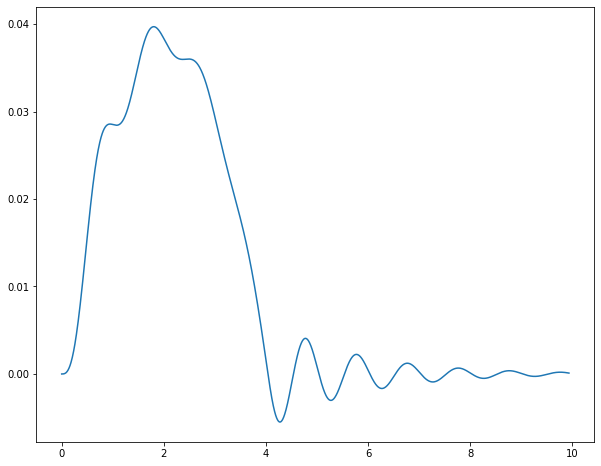

In [98]:
q = make_quad(15, 4, times)
xtq = conv_resp(gt, q)
fig, ax = plt.subplots()
ax.plot(times, xtq)
fig.set_size_inches(10, 8)
plt.show()

### Exponencial

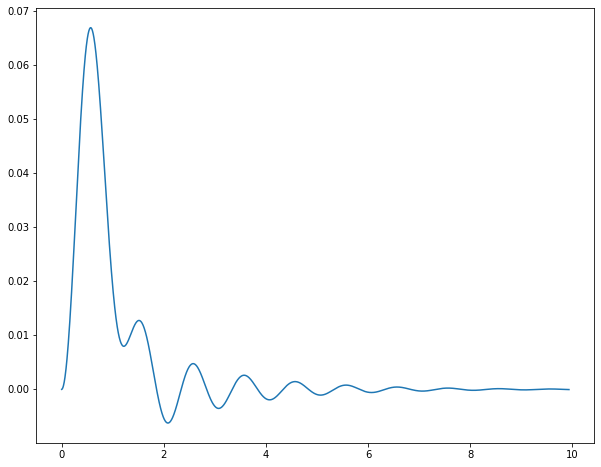

In [100]:
e = make_exp(10, 2.1, 2.0, times)
xte = conv_resp(gt, e)
fig, ax = plt.subplots()
ax.plot(times, xte)
fig.set_size_inches(10, 8)
plt.show()